# Tutorial on self-normalizing networks on the CIFAR-10 data set

Adapted from CIFAR10 tutorial from [exelban](https://github.com/exelban/tensorflow-cifar-10)

In [1]:
# imports

import pickle
import sys
import tarfile
import zipfile

import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
from math import sqrt

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

1.15.0


## Fetch Dataset

In [2]:
def get_data_set(name="train", cifar=10):
    x = None
    y = None
    l = None
    
    maybe_download_and_extract()
    
    folder_name = "cifar_10" if cifar == 10 else "cifar_100"
    
    f = open('./data_set/' + folder_name + '/batches.meta', 'rb')
    datadict = pickle.load(f, encoding='latin1')
    f.close()
    l = datadict['label_names']
    
    # mean and sdev of training set
    mean_train = 0.4733630004850902
    sdev_train = 0.2515689250632212
    
    if name is "train":
        for i in range(5):
            f = open('./data_set/' + folder_name + '/data_batch_' + str(i + 1), 'rb')
            datadict = pickle.load(f, encoding='latin1')
            f.close()
            
            _X = datadict["data"]
            _Y = datadict['labels']
            
            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, 3, 32, 32])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, 32 * 32 * 3)
            
            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)
        
        # Normalize Data to mean = 0, stdev = 1
        x = (x - mean_train) / sdev_train
    
    elif name is "test":
        f = open('./data_set/' + folder_name + '/test_batch', 'rb')
        datadict = pickle.load(f, encoding='latin1')
        f.close()
        
        x = datadict["data"]
        y = np.array(datadict['labels'])
        
        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, 3, 32, 32])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, 32 * 32 * 3)
        
        # Normalize Data according to mean and sdev of training set
        x = (x - mean_train) / sdev_train
    
    def dense_to_one_hot(labels_dense, num_classes=10):
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
        
        return labels_one_hot
    
    return x, dense_to_one_hot(y), l


def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()


def maybe_download_and_extract():
    main_directory = "./data_set/"
    cifar_10_directory = main_directory + "cifar_10/"
    cifar_100_directory = main_directory + "cifar_100/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)
        
        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)
        
        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")
        
        url = "http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_100 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)
        
        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")
        
        os.rename(main_directory + "./cifar-10-batches-py", cifar_10_directory)
        os.rename(main_directory + "./cifar-100-python", cifar_100_directory)
        os.remove(zip_cifar_10)
        os.remove(zip_cifar_100)

## Scaled ELU

In [3]:

def selu(x, name="selu"):
    """ When using SELUs you have to keep the following in mind:
    # (1) scale inputs to zero mean and unit variance
    # (2) use SELUs
    # (3) initialize weights with stddev sqrt(1/n)
    # (4) use SELU dropout
    """
    with ops.name_scope(name) as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

## Some helpers to build the network

In [4]:
def _variable_with_weight_decay(name, shape, activation, stddev, wd=None):    
    # Determine number of input features from shape
    f_in = np.prod(shape[:-1]) if len(shape) == 4 else shape[0]
    
    # Calculate sdev for initialization according to activation function
    if activation == selu:
        sdev = sqrt(1 / f_in)
    elif activation == tf.nn.relu:
        sdev = sqrt(2 / f_in)
    elif activation == tf.nn.elu:
        sdev = sqrt(1.5505188080679277 / f_in)
    else:
        sdev = stddev
    
    var = tf.get_variable(name=name, shape=shape,
                          initializer=tf.truncated_normal_initializer(stddev=sdev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [5]:
def conv2d(scope_name, input, activation, ksize, f_in, f_out, bias_init=0.0, stddev=5e-2):
    with tf.variable_scope(scope_name) as scope:
        kernel = _variable_with_weight_decay('weights', shape=[ksize, ksize, f_in, f_out], activation=activation,
                                             stddev=stddev)
        conv = tf.nn.conv2d(input, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.get_variable('biases', [f_out], initializer=tf.constant_initializer(bias_init), dtype=tf.float32)
        pre_activation = tf.nn.bias_add(conv, biases)
        return activation(pre_activation, name=scope.name)


def fc(scope_name, input, activation, n_in, n_out, stddev=0.04, bias_init=0.0, weight_decay=None):
    with tf.variable_scope(scope_name) as scope:
        weights = _variable_with_weight_decay('weights', shape=[n_in, n_out], activation=activation, stddev=stddev,
                                              wd=weight_decay)
        biases = tf.get_variable(name='biases', shape=[n_out], initializer=tf.constant_initializer(bias_init),
                                 dtype=tf.float32)
        return activation(tf.matmul(input, weights) + biases, name=scope.name)

## Build the model with a specified activation function

In [6]:
def model(activation):
    _IMAGE_SIZE = 32
    _IMAGE_CHANNELS = 3
    _NUM_CLASSES = 10
    _RESHAPE_SIZE = 4 * 4 * 128
    
    # set activation function
    act = selu if activation == "selu" else tf.nn.elu if activation == "elu" else tf.nn.relu
    
    with tf.variable_scope(activation):
        # input
        with tf.name_scope('data'):
            x = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE * _IMAGE_SIZE * _IMAGE_CHANNELS], name='Input')
            y = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')
            x_image = tf.reshape(x, [-1, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='images')
        
        # Conv 1
        conv1 = conv2d("conv1", input=x_image, activation=act, ksize=5, f_in=3, f_out=64)
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
        
        # Conv 2
        conv2 = conv2d("conv2", input=pool1, activation=act, ksize=5, f_in=64, f_out=64, bias_init=0.1)
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')
        
        # Conv 3-5
        conv3 = conv2d("conv3", input=pool2, activation=act, ksize=3, f_in=64, f_out=128)
        conv4 = conv2d("conv4", input=conv3, activation=act, ksize=3, f_in=128, f_out=128)
        conv5 = conv2d("conv5", input=conv4, activation=act, ksize=3, f_in=128, f_out=128)
        
        # Pool
        pool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3')
        
        # Reshape
        reshape = tf.reshape(pool3, [-1, _RESHAPE_SIZE])
        dim = reshape.get_shape()[1].value
        
        # Fully Connected
        fc1 = fc('fully_connected1', input=reshape, activation=act, n_in=dim, n_out=384, stddev=0.04, bias_init=0.1,
                 weight_decay=0.004)
        fc2 = fc('fully_connected2', input=fc1, activation=act, n_in=384, n_out=192, stddev=0.04, bias_init=0.1,
                 weight_decay=0.004)
        
        # Softmax
        with tf.variable_scope('output') as scope:
            weights = _variable_with_weight_decay('weights', [192, _NUM_CLASSES], stddev=1 / 192.0,
                                                  activation=activation,
                                                  wd=0.0)
            biases = tf.get_variable(name='biases', shape=[_NUM_CLASSES], initializer=tf.constant_initializer(0.0),
                                     dtype=tf.float32)
            softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name=scope.name)
            
            # output
            y_pred_cls = tf.argmax(softmax_linear, dimension=1)
        
        # Define Loss and Optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=softmax_linear, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
        
        correct_prediction = tf.equal(y_pred_cls, tf.argmax(y, dimension=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # tf.summary.scalar("Accuracy/train", accuracy)
    
    return {"x": x, "y": y, "output": y_pred_cls, "loss": loss, "accuracy": accuracy, "optimizer": optimizer, "name": activation}


## Evaluate on Test Set

In [7]:
def predict_test(test_x, test_y, models):
    """
        Make prediction for all images in test_x
    """
    i = 0
    predicted_class = {"selu": np.zeros(shape=len(test_x), dtype=np.int32),
                       "elu": np.zeros(shape=len(test_x), dtype=np.int32),
                       "relu":np.zeros(shape=len(test_x), dtype=np.int32)}
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        for name, model in models.items():
            predicted_class[name][i:j] = sess.run(model["output"], feed_dict={model['x']: batch_xs, model['y']: batch_ys})
        i = j
    
    accuracy = {"selu": 0, "elu": 0, "relu": 0}
    for name, model in models.items():
        correct = (np.argmax(test_y, axis=1) == predicted_class[name])        
        accuracy[name] = correct.mean() * 100        
    
    print("Accuracy on Test-Set (SELU/ELU/RELU): {0:.2f}% | {1:.2f}% | {2:.2f}%".format(
        accuracy["selu"], accuracy["elu"], accuracy["relu"]))
    
    return accuracy


## Plotting

In [8]:
def plot_metric(title, ylabel, metric):
    # Training Accuracy
    plt.figure()    
    plt.title(title, size="xx-large")
    plt.ylabel(ylabel, size="x-large")    
    plt.tick_params(axis="x", bottom="off", labelbottom="off")
    
    # select manually for consistent colors
    plt.plot(metric["selu"], label="SELU", linewidth=2)
    plt.plot(metric["elu"], label="ELU", linewidth=2)
    plt.plot(metric["relu"], label="RELU", linewidth=2)
        
    plt.legend()
    plt.show()

def plot(train_loss, train_accuracy, test_accuracy):    
    # Training Loss
    plot_metric("Training Loss", "Loss", train_loss)
    
    # Training Accuracy
    plot_metric("Training Accuracy", "Accuracy", train_accuracy)
    
    # Test Accuracy
    plot_metric("Test Accuracy", "Accuracy", test_accuracy)

## Training

In [9]:
def train(session, num_iterations, train_x, train_y, test_x, test_y, models, global_step):
    """
        Train CNN
    """    
    train_loss = {"selu": [], "elu":[], "relu": []}
    train_accuracy = {"selu": [], "elu":[], "relu": []}    
    test_accuracy = {"selu": [], "elu":[], "relu": []}
    
    inc_step_op = tf.assign(global_step, global_step+1)
    # start training
    for i in range(num_iterations):
        randidx = np.random.randint(len(train_x), size=_BATCH_SIZE)
        batch_xs = train_x[randidx]
        batch_ys = train_y[randidx]
                
        optimizers = []
        feed_dict = {}
        for name, model in models.items():
            optimizers.append(model["optimizer"])
            feed_dict.update({model["x"]: batch_xs, model["y"]: batch_ys})
        
        # current step
        i_global = session.run(global_step)
        
        # train
        session.run( optimizers, feed_dict=feed_dict)
        
        # print training loss
        if (i_global % 10 == 0) or (i == num_iterations - 1):
            l_selu, l_elu, l_relu, acc_selu, acc_elu, acc_relu = session.run(
                [models['selu']['loss'], models['elu']['loss'], models['relu']['loss'], 
                 models['selu']['accuracy'], models['elu']['accuracy'], models['relu']['accuracy']],
                feed_dict=feed_dict)
            
            msg = "Global Step: {0:>6}, " \
                  "accuracy (SELU/ELU/RELU): {1:>6.1%} | {2:>6.1%} | {3:>6.1%}, " \
                  "loss (SELU/ELU/RELU): {4:.2f} | {5:.2f} | {6:.2f}"
            print(msg.format(i_global, acc_selu, acc_elu, acc_relu, l_selu, l_elu, l_relu))            
            
            # collect metrics for plots                            
            train_loss["selu"].append(l_selu)
            train_loss["elu"].append(l_elu)
            train_loss["relu"].append(l_relu)
            train_accuracy["selu"].append(acc_selu)
            train_accuracy["elu"].append(acc_elu)
            train_accuracy["relu"].append(acc_relu)

        # evaluate test set accuracy
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            acc = predict_test(test_x, test_y, models)                
            test_accuracy["selu"].append(acc["selu"])
            test_accuracy["elu"].append(acc["elu"])
            test_accuracy["relu"].append(acc["relu"])
            saver.save(session, save_path=_SAVE_PATH + "/checkpoint", global_step=global_step)
            print("Saved checkpoint.")
        
        # increment global step
        session.run(inc_step_op)
    return train_loss, train_accuracy, test_accuracy

## Parameters

In [10]:
_IMG_SIZE = 32
_NUM_CHANNELS = 3
_BATCH_SIZE = 128
_CLASS_SIZE = 10
_ITERATION = 10000
_SAVE_PATH = "./checkpoints/cifar-10"

In [11]:
import os

# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if not os.path.exists(_SAVE_PATH):
    os.makedirs(_SAVE_PATH)

## Create Models

In [12]:
# Build Graph
relu = model("relu")
selu = model("selu")
elu = model("elu")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Run Training

In [13]:
# Some Tensorflow configuration
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True

# Initialize Dataset
train_x, train_y, train_l = get_data_set("train", cifar=10)
test_x, test_y, test_l = get_data_set("test", cifar=10)

# step counter
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

saver = tf.train.Saver()
with tf.Session(config=tf_config) as sess:
    try:
        print("Trying to restore last checkpoint ...")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
        saver.restore(sess, save_path=last_chk_path)
        print("Restored checkpoint from:", last_chk_path)
    except:
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())
    
    if _ITERATION != 0:
        train_loss, train_accuracy, test_accuracy = train(
            sess, _ITERATION, train_x, train_y, test_x, test_y, 
            models={"relu": relu, "selu": selu, "elu": elu}, 
            global_step=global_step)

- Download progress: 100.0%
Download finished. Extracting files.
Done.
- Download progress: 100.0%
Download finished. Extracting files.
Done.
Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.
Global Step:      0, accuracy (SELU/ELU/RELU):  14.8% |  14.8% |  10.9%, loss (SELU/ELU/RELU): 2.27 | 2.28 | 2.28
Accuracy on Test-Set (SELU/ELU/RELU): 10.65% | 11.28% | 10.00%
Saved checkpoint.
Global Step:     10, accuracy (SELU/ELU/RELU):  21.9% |  22.7% |  18.0%, loss (SELU/ELU/RELU): 2.17 | 2.18 | 2.24
Global Step:     20, accuracy (SELU/ELU/RELU):  32.0% |  32.8% |  25.8%, loss (SELU/ELU/RELU): 2.01 | 2.00 | 2.13
Global Step:     30, accuracy (SELU/ELU/RELU):  32.8% |  35.9% |  29.7%, loss (SELU/ELU/RELU): 1.93 | 1.86 | 1.92
Global Step:     40, accuracy (SELU/ELU/RELU):  34.4% |  34.4% |  32.0%, loss (SELU/ELU/RELU): 1.92 | 1.89 | 1.90
Global Step:     50, accuracy (SELU/ELU/RELU):  35.2% |  33.6% |  27.3%, loss (SELU/ELU/RELU): 1.88 | 1.86 

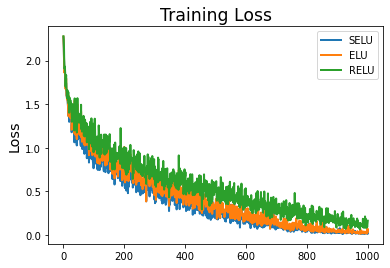

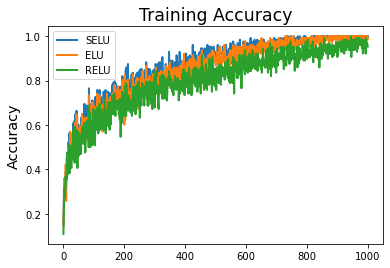

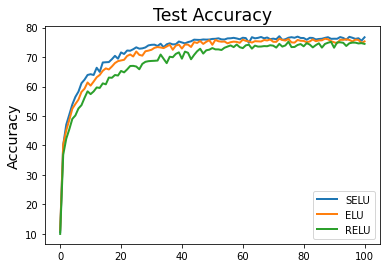

In [14]:
# Plot Training Loss, Training Accuracy and Test Accuracy for the three activation functions
plot(train_loss, train_accuracy, test_accuracy)        